# Factorized Graded Response Model with Stochastic Imputation

This notebook demonstrates fitting a **FactorizedGRModel** from `bayesianquilts.irt` to the
Right-Wing Authoritarianism (RWA) scale dataset, with stochastic imputation of missing responses.

Key features shown:
- Loading the RWA dataset (22 items, 9 response categories, 2 latent dimensions)
- Introducing artificial missingness
- Fitting a **MICEBayesianLOO** imputation model
- Fitting a FactorizedGRModel **without** imputation (zero-fill baseline)
- Fitting a FactorizedGRModel **with** stochastic imputation
- Comparing results

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['JAX_PLATFORMS'] = 'cpu'

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

## 1. Load and Explore the RWA Dataset

In [2]:
from bayesianquilts.data.rwa import (
    get_data, item_keys, item_text, to_reverse, scale_indices
)

df, num_people = get_data(polars_out=True)
print(f"Dataset shape: {df.shape}")
print(f"Number of people: {num_people}")
print(f"Number of items: {len(item_keys)}")
print(f"Response categories: 0-8 (9 levels)")
print(f"\nScale 1 items ({len(scale_indices[0])} items): {[item_keys[i] for i in scale_indices[0]]}")
print(f"Scale 2 items ({len(scale_indices[1])} items): {[item_keys[i] for i in scale_indices[1]]}")
df.head()

Dataset shape: (9881, 23)
Number of people: 9881
Number of items: 22
Response categories: 0-8 (9 levels)

Scale 1 items (12 items): ['Q2', 'Q4', 'Q6', 'Q8', 'Q9', 'Q11', 'Q13', 'Q15', 'Q16', 'Q18', 'Q20', 'Q21']
Scale 2 items (10 items): ['Q1', 'Q3', 'Q5', 'Q7', 'Q10', 'Q12', 'Q14', 'Q17', 'Q19', 'Q22']


person,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22
u32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,3,0,0,8,2,8,1,6,7,0,8,0,8,0,8,0,0,8,1,8,8,0
1,2,1,0,7,1,6,0,7,8,2,6,4,8,1,8,0,0,7,0,6,6,0
2,0,5,6,8,2,8,8,3,8,8,7,8,8,7,8,1,8,2,4,6,8,8
3,0,0,0,7,0,7,0,8,8,0,8,1,7,0,7,0,0,8,0,8,8,0
4,0,0,0,2,0,8,0,0,6,0,8,1,8,4,8,0,0,2,0,8,3,0


In [3]:
# Subsample for faster fitting in this demo
SUBSAMPLE_N = 500
rng = np.random.default_rng(42)
idx = rng.choice(num_people, size=SUBSAMPLE_N, replace=False)
idx.sort()

sub_df = df[idx.tolist()]
print(f"Subsample size: {len(sub_df)}")

Subsample size: 500


## 2. Introduce Artificial Missingness

The RWA dataset has very low natural missingness (~0.3%). To demonstrate
imputation, we randomly mask 15% of responses as missing.

> **A note on ignorability and misspecification.** Under the classical
> Rubin (1976) framework, a Missing At Random (MAR) mechanism is
> *ignorable* for likelihood-based inference when the model is correctly
> specified (*M-closed*). In the **M-open** regime --- where the true
> data-generating process is not contained in the model class --- MAR is
> **not sufficient for ignorability**. Misspecification couples the
> missingness pattern to estimation bias, so explicit imputation is
> necessary even when the probability of being missing does not depend
> on the unobserved values.

In [4]:
import polars as pl

MISSING_RATE = 0.15
rng_miss = np.random.default_rng(99)

# Start with the subsample and convert -1 (original missing) to NaN
sub_df_missing = sub_df.with_columns([
    pl.when(pl.col(k) == -1).then(None).otherwise(pl.col(k)).alias(k)
    for k in item_keys
])

# Add artificial MCAR missingness
mask_arrays = {}
for k in item_keys:
    mask = rng_miss.random(SUBSAMPLE_N) < MISSING_RATE
    mask_arrays[k] = mask

sub_df_missing = sub_df_missing.with_columns([
    pl.when(pl.Series(mask_arrays[k])).then(None).otherwise(pl.col(k)).alias(k)
    for k in item_keys
])

# Count missingness
total_missing = sum(sub_df_missing[k].null_count() for k in item_keys)
total_cells = SUBSAMPLE_N * len(item_keys)
print(f"Total missing: {total_missing}/{total_cells} ({100*total_missing/total_cells:.1f}%)")
print(f"\nMissing per item:")
for k in item_keys[:5]:
    print(f"  {k}: {sub_df_missing[k].null_count()}")
print(f"  ...")

Total missing: 1669/11000 (15.2%)

Missing per item:
  Q1: 61
  Q2: 60
  Q3: 86
  Q4: 81
  Q5: 102
  ...


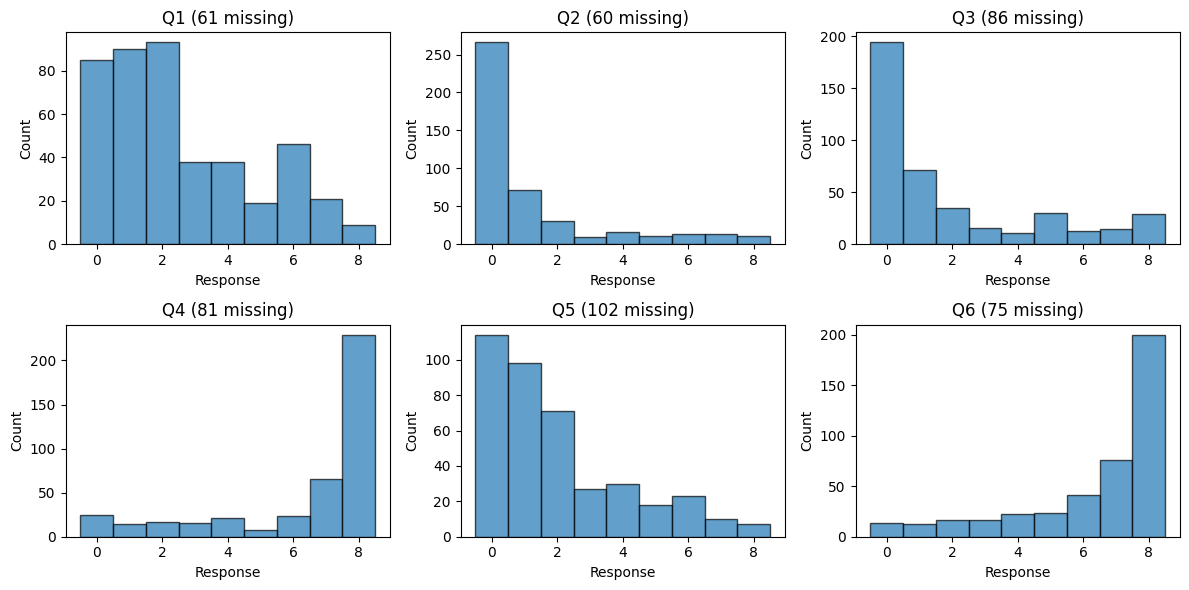

In [5]:
# Response distributions for a few items (observed only)
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for ax, k in zip(axes.flat, item_keys[:6]):
    vals = sub_df_missing[k].drop_nulls().to_numpy()
    ax.hist(vals, bins=np.arange(-0.5, 9.5, 1), edgecolor='black', alpha=0.7)
    n_miss = sub_df_missing[k].null_count()
    ax.set_title(f'{k} ({n_miss} missing)')
    ax.set_xlabel('Response')
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

## 3. Fit a MICEBayesianLOO Imputation Model

We fit a Bayesian LOO-CV stacking model that can predict any item from the
other observed items. This model will be used during IRT fitting to stochastically
fill in missing responses.

In [6]:
from bayesianquilts.imputation.mice_loo import MICEBayesianLOO

# Convert to pandas with NaN for missing (MICEBayesianLOO expects pandas)
imputation_df = sub_df_missing.select(item_keys).to_pandas()
print(f"Imputation DataFrame shape: {imputation_df.shape}")
print(f"NaN count: {imputation_df.isna().sum().sum()}")

mice_loo = MICEBayesianLOO(
    random_state=42,
    prior_scale=1.0,
    pathfinder_num_samples=100,
    pathfinder_maxiter=50,
    batch_size=512,
    verbose=True,
)

mice_loo.fit_loo_models(
    X_df=imputation_df,
    fit_zero_predictors=True,
    n_jobs=-1,
    n_top_features=22,  # All items as potential predictors
    seed=42,
)

print(f"\nFitted variable names: {mice_loo.variable_names[:5]}...")
print(f"Variable types: {dict(list(mice_loo.variable_types.items())[:5])}...")
print(f"Zero-predictor models: {len(mice_loo.zero_predictor_results)}")
print(f"Univariate models: {len(mice_loo.univariate_results)}")

Imputation DataFrame shape: (500, 22)
NaN count: 1669
Computing feature correlations...
Fitting MICE Bayesian LOO-CV models with Pathfinder
  Variables: 22
  Observations: 500
  Min obs per model: 5
  Parallel jobs: -1
  Top features per target: 22
  Global Ordinal Values: [0. 1. 2. 3. 4. 5. 6. 7. 8.] (n=9)

Fitting zero-predictor models...
  Scheduling 22 zero-predictor jobs...
  Var 0 (Q1): n_obs=439, elpd/n=-2.0077
  Var 1 (Q2): n_obs=440, elpd/n=-1.3931
  Var 2 (Q3): n_obs=414, elpd/n=-1.7149
  Var 3 (Q4): n_obs=419, elpd/n=-1.5676
  Var 4 (Q5): n_obs=398, elpd/n=-1.8770
  Var 5 (Q6): n_obs=425, elpd/n=-1.7048
  Var 6 (Q7): n_obs=421, elpd/n=-1.7710
  Var 7 (Q8): n_obs=418, elpd/n=-1.9921
  Var 8 (Q9): n_obs=430, elpd/n=-1.7776
  Var 9 (Q10): n_obs=423, elpd/n=-1.9420
  Var 10 (Q11): n_obs=420, elpd/n=-1.6351
  Var 11 (Q12): n_obs=425, elpd/n=-2.0918
  Var 12 (Q13): n_obs=418, elpd/n=-1.9045
  Var 13 (Q14): n_obs=438, elpd/n=-1.9836
  Var 14 (Q15): n_obs=429, elpd/n=-2.0049
  Var 1

/Users/changjc/workspace/bayesianquilts/env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  Processing Q20 (21 valid predictors)
  Processing Q21 (21 valid predictors)
  Processing Q22 (21 valid predictors)

Fitted variable names: ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']...
Variable types: {0: 'ordinal', 1: 'ordinal', 2: 'ordinal', 3: 'ordinal', 4: 'ordinal'}...
Zero-predictor models: 22
Univariate models: 462


In [7]:
# Test a single prediction
# Predict Q1 given some observed items
observed = {item_keys[i]: float(sub_df_missing[item_keys[i]][0]) 
            for i in range(1, 22) 
            if sub_df_missing[item_keys[i]][0] is not None}
result = mice_loo.predict(observed, target='Q1', return_details=True)
print(f"Predicted Q1: {result['prediction']:.2f}")
print(f"Stacking weights: {result['weights']}")

Predicted Q1: 2.30
Stacking weights: {'intercept': 9.241243864442586e-95, 'Q2': 5.521852082350609e-26, 'Q3': 1.2698709812840224e-08, 'Q4': 2.5271000413685813e-19, 'Q6': 1.5157115540980562e-27, 'Q7': 5.3381321433339875e-05, 'Q8': 9.392597649911815e-22, 'Q9': 5.546371206707935e-25, 'Q10': 1.1718707950056719e-20, 'Q11': 2.764305010751764e-34, 'Q12': 2.0758312967661512e-16, 'Q13': 1.275308544387823e-18, 'Q14': 4.804462134155456e-31, 'Q15': 2.0954325600992512e-11, 'Q17': 6.7578022103107275e-19, 'Q18': 4.905084705817792e-28, 'Q19': 0.9999466059588982, 'Q20': 8.528295893663147e-34, 'Q21': 1.8227439380762461e-28, 'Q22': 3.946637600466849e-15}


## 4. Fit FactorizedGRModel WITHOUT Imputation (Baseline)

First, fit the model using the default zero-fill strategy for missing data.
Missing responses have their log-likelihood zeroed out.

In [8]:
from bayesianquilts.irt.factorizedgrm import FactorizedGRModel

def make_data_dict(dataframe):
    """Convert polars DataFrame to dict of numpy float64 arrays.
    
    Null/None values become NaN, which the IRT model detects as missing.
    """
    data = {}
    for col in dataframe.columns:
        arr = dataframe[col].to_numpy().astype(np.float64)
        data[col] = arr
    # Re-index persons to 0..N-1
    data['person'] = np.arange(len(dataframe), dtype=np.float64)
    return data

batch = make_data_dict(sub_df_missing)

# Verify missingness in the batch
n_bad_total = 0
for k in item_keys:
    col = batch[k]
    n_bad = np.sum(np.isnan(col) | (col < 0) | (col >= 9))
    n_bad_total += n_bad
print(f"Total bad/missing values in batch: {n_bad_total}")

# Minibatch setup
BATCH_SIZE = 64
steps_per_epoch = int(np.ceil(SUBSAMPLE_N / BATCH_SIZE))
print(f"Batch size: {BATCH_SIZE}, Steps per epoch: {steps_per_epoch}")

def data_factory():
    # Simple shuffling and batching
    indices = np.arange(SUBSAMPLE_N)
    np.random.shuffle(indices)
    for start_idx in range(0, SUBSAMPLE_N, BATCH_SIZE):
        end_idx = min(start_idx + BATCH_SIZE, SUBSAMPLE_N)
        idx_batch = indices[start_idx:end_idx]
        # Slice the batch dict
        yield {k: v[idx_batch] for k, v in batch.items()}

Total bad/missing values in batch: 1669
Batch size: 64, Steps per epoch: 8


In [9]:
NUM_EPOCHS = 200

model_baseline = FactorizedGRModel(
    scale_indices=scale_indices,
    kappa_scale=0.1,
    item_keys=item_keys,
    num_people=SUBSAMPLE_N,
    response_cardinality=9,
    dtype=jnp.float64,
)

losses_baseline, params_baseline = model_baseline.fit(
    data_factory,
    batch_size=BATCH_SIZE,
    dataset_size=SUBSAMPLE_N,
    num_epochs=NUM_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    learning_rate=2e-4,
    patience=10,
)

print(f"Baseline final loss: {losses_baseline[-1]:.2f}")

--- Starting Training ---
Patience for early stopping: 10 epochs
LR decay factor on plateau: 0.5
Convergence will be checked every: 1 epoch(s)
Checkpoints will be saved to: /tmp/checkpoints
Optimizing keys: ['discriminations_0\\softplus\\normal\\loc', 'discriminations_0\\softplus\\normal\\scale', 'difficulties0_0\\identity\\normal\\loc', 'difficulties0_0\\identity\\normal\\scale', 'ddifficulties_0\\softplus\\normal\\loc', 'ddifficulties_0\\softplus\\normal\\scale', 'abilities_0\\identity\\normal\\loc', 'abilities_0\\identity\\normal\\scale', 'discriminations_1\\softplus\\normal\\loc', 'discriminations_1\\softplus\\normal\\scale', 'difficulties0_1\\identity\\normal\\loc', 'difficulties0_1\\identity\\normal\\scale', 'ddifficulties_1\\softplus\\normal\\loc', 'ddifficulties_1\\softplus\\normal\\scale', 'abilities_1\\identity\\normal\\loc', 'abilities_1\\identity\\normal\\scale']
-------------------------


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    

  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    

--- Training Finished ---
Restored model from checkpoint: /tmp/checkpoints/best_model_199
Baseline final loss: 3081.97


## 5. Fit FactorizedGRModel WITH Stochastic Imputation

Now fit the same model but with the MICEBayesianLOO imputation model.
At each training step, missing values are stochastically filled from the
imputation model's predictive distribution before computing the log-likelihood.

In [10]:
N_IMPUTATION_SAMPLES = 3

model_imputed = FactorizedGRModel(
    scale_indices=scale_indices,
    kappa_scale=0.1,
    item_keys=item_keys,
    num_people=SUBSAMPLE_N,
    response_cardinality=9,
    dtype=jnp.float64,
    imputation_model=mice_loo,
)

# Validate the imputation model first
model_imputed.validate_imputation_model()
print("Imputation model validation passed.")

losses_imputed, params_imputed = model_imputed.fit(
    data_factory,
    batch_size=BATCH_SIZE,
    dataset_size=SUBSAMPLE_N,
    num_epochs=NUM_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    learning_rate=2e-4,
    patience=10,
    n_imputation_samples=N_IMPUTATION_SAMPLES,
)

print(f"Imputed final loss: {losses_imputed[-1]:.2f}")

Imputation model validation passed.


/Users/changjc/workspace/bayesianquilts/python/bayesianquilts/irt/irt.py:220: UserWarning: Items with high PSIS khat (>= 0.7), imputation may be unreliable: ['Q19']
  warnings.warn(


--- Starting Training ---
Patience for early stopping: 10 epochs
LR decay factor on plateau: 0.5
Convergence will be checked every: 1 epoch(s)
Checkpoints will be saved to: /tmp/checkpoints
Optimizing keys: ['discriminations_0\\softplus\\normal\\loc', 'discriminations_0\\softplus\\normal\\scale', 'difficulties0_0\\identity\\normal\\loc', 'difficulties0_0\\identity\\normal\\scale', 'ddifficulties_0\\softplus\\normal\\loc', 'ddifficulties_0\\softplus\\normal\\scale', 'abilities_0\\identity\\normal\\loc', 'abilities_0\\identity\\normal\\scale', 'discriminations_1\\softplus\\normal\\loc', 'discriminations_1\\softplus\\normal\\scale', 'difficulties0_1\\identity\\normal\\loc', 'difficulties0_1\\identity\\normal\\scale', 'ddifficulties_1\\softplus\\normal\\loc', 'ddifficulties_1\\softplus\\normal\\scale', 'abilities_1\\identity\\normal\\loc', 'abilities_1\\identity\\normal\\scale']
-------------------------


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000100


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000050


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000025


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000013


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000006


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000003


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000002


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000001


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 3 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 3 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 3 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 4 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 3 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 4 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 5 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 3 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 4 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 5 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 3 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 4 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 5 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 2 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> No improvement in loss for 3 check(s).                    
  -> Decaying learning rate to: 0.000000


  -> New best loss found. Checkpoint saved.                    


  -> No improvement in loss for 1 check(s).                    
  -> Decaying learning rate to: 0.000000

--- Training Finished ---
Restored model from checkpoint: /tmp/checkpoints/best_model_198
Imputed final loss: 3396.21


## 6. Compare Results

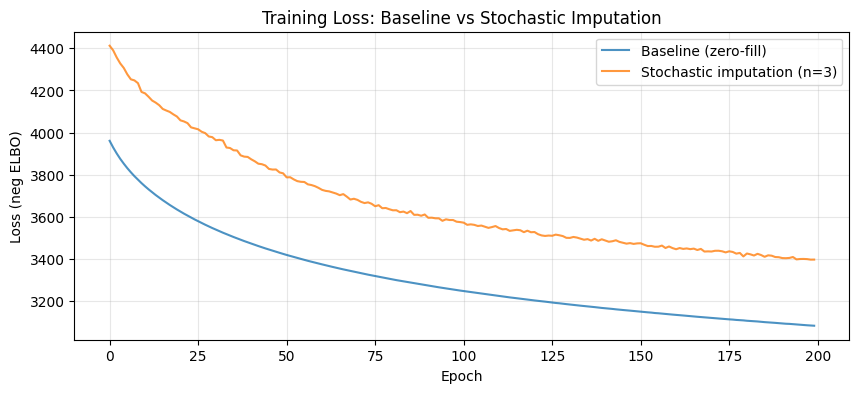

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(losses_baseline, label='Baseline (zero-fill)', alpha=0.8)
plt.plot(losses_imputed, label=f'Stochastic imputation (n={N_IMPUTATION_SAMPLES})', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (neg ELBO)')
plt.title('Training Loss: Baseline vs Stochastic Imputation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

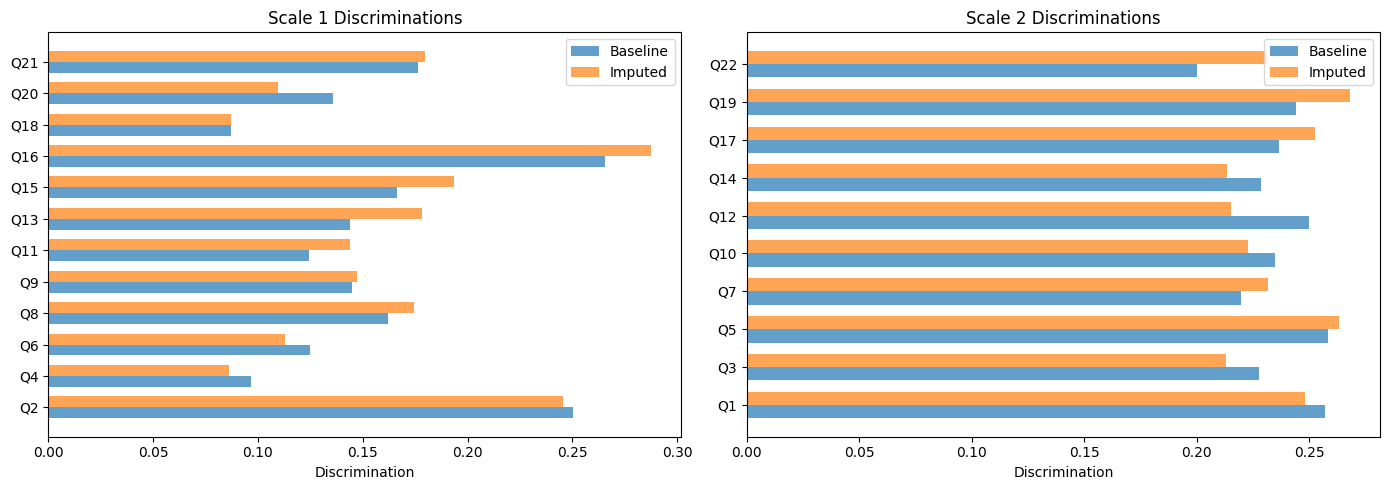

In [12]:
# Compare discrimination estimates
def calibrate_manually(model, n_samples=32, seed=42):
    # Generate the surrogate distribution from current params
    surrogate = model.surrogate_distribution_generator(model.params)
    
    # Sample with a specific key
    key = jax.random.PRNGKey(seed)
    samples = surrogate.sample(n_samples, seed=key)
    
    # Compute expectations (means) for all parameters
    expectations = {}
    for k, v in samples.items():
        # v has shape (n_samples, ...)
        expectations[k] = jnp.mean(v, axis=0)
        
    model.calibrated_expectations = expectations

calibrate_manually(model_baseline, n_samples=20, seed=101)
calibrate_manually(model_imputed, n_samples=20, seed=102)

fig, axes = plt.subplots(1, len(scale_indices), figsize=(14, 5))

for j, (indices, ax) in enumerate(zip(scale_indices, axes)):
    key = f'discriminations_{j}'
    disc_base = np.array(model_baseline.calibrated_expectations[key]).flatten()
    disc_imp = np.array(model_imputed.calibrated_expectations[key]).flatten()
    labels = [item_keys[i] for i in indices]
    
    x = np.arange(len(labels))
    width = 0.35
    ax.barh(x - width/2, disc_base, width, label='Baseline', alpha=0.7)
    ax.barh(x + width/2, disc_imp, width, label='Imputed', alpha=0.7)
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.set_title(f'Scale {j+1} Discriminations')
    ax.set_xlabel('Discrimination')
    ax.legend()

plt.tight_layout()
plt.show()

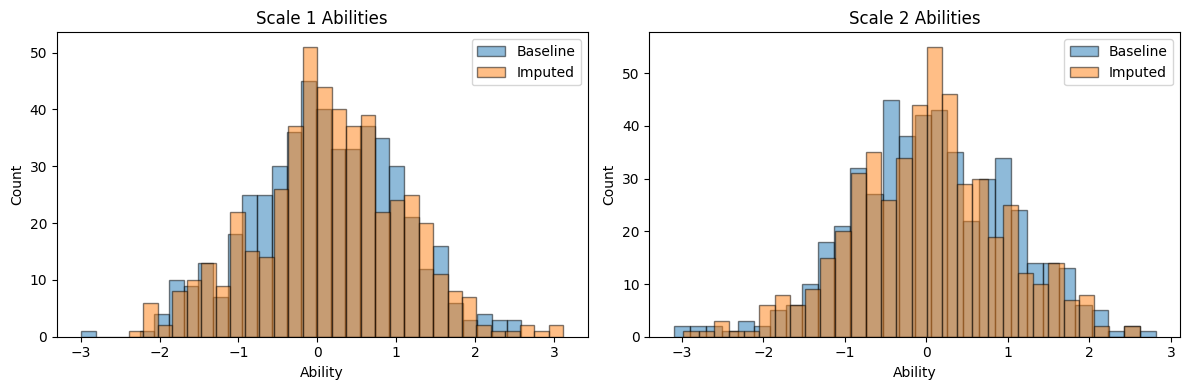

In [13]:
# Compare ability distributions
fig, axes = plt.subplots(1, len(scale_indices), figsize=(12, 4))

for j, ax in enumerate(axes):
    key = f'abilities_{j}'
    ab_base = np.array(model_baseline.calibrated_expectations[key]).flatten()
    ab_imp = np.array(model_imputed.calibrated_expectations[key]).flatten()
    ax.hist(ab_base, bins=30, alpha=0.5, label='Baseline', edgecolor='black')
    ax.hist(ab_imp, bins=30, alpha=0.5, label='Imputed', edgecolor='black')
    ax.set_title(f'Scale {j+1} Abilities')
    ax.set_xlabel('Ability')
    ax.set_ylabel('Count')
    ax.legend()

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

1. **Data loading**: The `bayesianquilts.data.rwa` module downloads and preprocesses the RWA scale data without requiring `autoencirt`.
2. **Artificial missingness**: We randomly masked 15% of responses to simulate MCAR missingness.
3. **MICEBayesianLOO**: A Bayesian stacking imputation model was fitted to predict missing items from observed ones.
4. **Baseline (zero-fill)**: The FactorizedGRModel handles missing responses by zeroing their log-likelihood contributions.
5. **Stochastic imputation with Rao-Blackwellization**: By passing `imputation_model` to the FactorizedGRModel and `n_imputation_samples` to `fit()`, missing values are stochastically filled at each training step. The implementation uses proper Rao-Blackwellization: for each batch with missing data, M imputed copies are generated and the marginalized log-likelihood is computed as $\log\left[\frac{1}{M}\sum_m p(y_\text{obs}, y_\text{miss}^{(m)} \mid \theta)\right] = \mathrm{logsumexp}_m\left[\log p(y_\text{obs}, y_\text{miss}^{(m)} \mid \theta)\right] - \log M$. This averages likelihoods (not log-likelihoods), avoiding the Jensen's inequality lower bound that would result from treating each imputed copy as a separate mini-batch.
6. **Comparison**: Both approaches produce parameter estimates; stochastic imputation corrects for missingness in the presence of misspecification.